# Long Short Term Memory

In [1]:
import torch
import torch.nn as nn
from d2l import torch as d2l

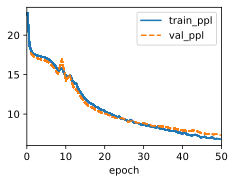

In [2]:
class LSTMScratch(d2l.Module):
    """LSTM implementation from scratch"""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        init_weight = lambda * shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  #Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  #Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  #Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  #Input node

    def forward(self, inputs, H_C = None):
        if H_C is None:
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
            C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            H, C = H_C
        outputs = []
        for X in inputs:
            I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)
    
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

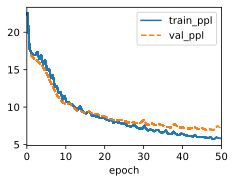

In [3]:
class LSTM(d2l.RNN):
    """Concise Implementation of RNN"""
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)
        
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [4]:
model.predict('the day', 20, data.vocab, d2l.try_gpu())

'the day a man and the time '

# Gated Recurrent Unit

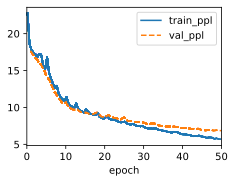

In [6]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

    def forward(self, inputs, H=None):
        if H is None:
            H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            outputs.append(H)
        return outputs, H
    
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

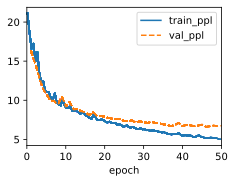

In [8]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
    
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [9]:
model.predict('the day', 20, data.vocab, d2l.try_gpu())

'the day the the the the the'

# Deep RNN

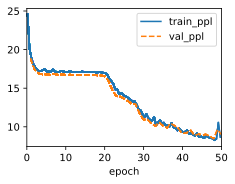

In [10]:
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])
        
    def forward(self, inputs, Hs=None):
        outputs = inputs
        if Hs is None:
            Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = torch.stack(outputs, 0)
        return outputs, Hs
    
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

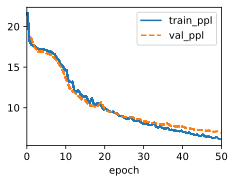

In [11]:
class GRU(d2l.RNN):
    """Concise Implementation of multilayer GRU"""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout = 0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [16]:
model.predict('the day', 20, data.vocab, d2l.try_gpu())

'the day the the the the the'